### **Importing Libraries**

In [ ]:
import math
import random
from collections import defaultdict
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
import copy
from Card_and_Deck import *
from GameState import GameState
from Game_and_Player import *
import time

### **MCTS Node Class**

In [ ]:
class MCTSNode:
    node_counter = 0
    def __init__(self, game_state, parent=None,move_taken=None,owner=None):
        self.game_state = game_state  # The game state at tho;his node
        self.parent = parent  # Parent node
        self.children = []  # List of child nodes
        self.visits = 1  # Number of times this node has been visited
        self.total_reward = 0  # Total reward (tricks won)
        self.untried_moves = list(self.game_state.get_legal_moves())  # Legal moves from this state
        self.move_taken = move_taken # move that led to this game state
        self.visited_nodes = {}
        self.owner=owner

    def expand(self,move):
          if move not in self.untried_moves:
            print(f"Warning: Move {move} not found in untried_moves!")
            print(f"Current untried_moves: {self.untried_moves}")
            return None


          game_state = self.game_state
          new_game_state = copy.deepcopy(game_state)
          self.untried_moves.remove(move)
          node_owner = self.game_state.players[self.game_state.current_player_index].name
          child_game_state = new_game_state.apply_move(move)

          child_node = MCTSNode(child_game_state, parent=self, move_taken=move,owner= node_owner)
          self.children.append(child_node)

          return child_node


    def simulate(self, game_state,current_name):

          game_state_new = copy.deepcopy(game_state)

          while not game_state_new.is_terminal():
              legal_moves = game_state_new.get_legal_moves()
              if not legal_moves:
                  break
              move = random.choice(legal_moves)
              game_state_new.apply_move(move)

          rewards = {}

          for player in game_state_new.players:
              player_tricks = game_state_new.tricks_won[player.name]
              rewards[player.name] = player_tricks/10
          return rewards


    def backpropagate(self, rewards):

          self.visits += 1

          if self.owner:
              reward = rewards.get(self.owner, 0)
              self.total_reward += reward

          if self.parent:
              self.parent.backpropagate(rewards)


    def ucb1(self,child, c=0.707):

        parent_visits = child.parent.visits

        if child.visits == 0:
            return float("inf")
        ucb_val= (child.total_reward / child.visits) + c * math.sqrt(2*math.log(parent_visits) / child.visits)
        return ucb_val


    def best_child(self, c=4):
        node = self
        if not self.children:
            print("No children found! Returning None.")
            return None
        best = max(node.children, key=lambda child: node.ucb1(child, c))
        return best



    def tree_policy(self, c=1.4):
          current_node = self
          depth = 0
          while not current_node.game_state.is_terminal():
              if current_node.untried_moves:
                  move = random.choice(current_node.untried_moves)
                  return current_node
              else:
                  current_node = current_node.best_child(c)  # v ← BESTCHILD(v, Cp)
                  depth += 1
          return current_node


### **MCTS Search Function**

In [ ]:

def mcts_search(root_node, num_simulations=100,c=0.707):

    game_state_new = root_node.game_state


    root = root_node
    current_name = root_node.game_state.players[root_node.game_state.current_player_index].name

    for _ in range(num_simulations):
        node = root
        root.visits += 1

        # Tree Traversal
        node = node.tree_policy(c)


        # Expansion
        if node.untried_moves:
            move = random.choice(node.untried_moves)
            node = node.expand(move)


        # Simulation
        reward = node.simulate(node.game_state,current_name)

        # Backpropagation
        node.backpropagate(reward)

    best_child = max(root_node.children, key=lambda child: child.total_reward / (child.visits + 1e-6))

    return best_child.move_taken


### **UCB**

In [ ]:
def simulate(game_state):
    """Simulates a random game from this state (play out the game to the end)."""
    game_state_new = copy.deepcopy(game_state)
    starting_player_index = game_state.current_player_index
    starting_player_name = game_state.players[starting_player_index].name

    while not game_state_new.is_terminal():
        legal_moves = game_state_new.get_legal_moves()
        if not legal_moves:
            break
        move = random.choice(legal_moves)
        game_state_new.apply_move(move)

    rewards=game_state_new.tricks_won

    winner_name = max(rewards, key=rewards.get)

    winner_index = next(i for i, player in enumerate(game_state_new.players) if player.name == winner_name)


    return winner_index

def ucb_best_move(game_state, num_simulations=1000, exploration_constant=0.4):
    legal_moves = game_state.get_legal_moves()
    sum_scores = {(move.suit,move.rank): 0.0 for move in legal_moves}
    visit_counts = {(move.suit,move.rank): 0 for move in legal_moves}

    for i in range(num_simulations):
        best_score = -float('inf')
        best_move = None

        for move in legal_moves:
            if visit_counts[(move.suit,move.rank)] == 0:
                score = float('inf')  # force exploration
            else:
                avg_score = sum_scores[(move.suit,move.rank)] / visit_counts[(move.suit,move.rank)]
                score = avg_score + exploration_constant * math.sqrt(
                    math.log(i + 1) / visit_counts[(move.suit,move.rank)]
                )

            if score > best_score:
                best_score = score
                best_move = move

        sim_state = copy.deepcopy(game_state)
        sim_state.apply_move(best_move)

        winner = simulate(sim_state)

        if winner == game_state.current_player_index:
            sum_scores[(best_move.suit,best_move.rank)] += 1
        else:
            sum_scores[(best_move.suit,best_move.rank)] += 0


        visit_counts[(best_move.suit,best_move.rank)] += 1

    best_move = max(legal_moves, key=lambda m: visit_counts[(m.suit,m.rank)])
    return best_move


### **Sequential Halving**

In [ ]:
def simulate(game_state):
    """Simulates a random game from this state (play out the game to the end)."""
    game_state_new = copy.deepcopy(game_state)
    starting_player_index = game_state.current_player_index
    starting_player_name = game_state.players[starting_player_index].name

    while not game_state_new.is_terminal():
        legal_moves = game_state_new.get_legal_moves()
        if not legal_moves:
            break
        move = random.choice(legal_moves)
        game_state_new.apply_move(move)

    rewards=game_state_new.tricks_won

    winner_name = max(rewards, key=rewards.get)

    winner_index = next(i for i, player in enumerate(game_state_new.players) if player.name == winner_name)


    return winner_index

def sequential_halving_flat(state, budget):
    moves = state.get_legal_moves()
    # print(f"legal moves:{moves}")
    total_moves = len(moves)

    nplayouts = {(m.suit,m.rank): 0 for m in moves}
    nwins = {(m.suit,m.rank): 0 for m in moves}

    current_index = state.current_player_index

    while len(moves) > 1:
        sims_per_move = int(budget // (len(moves) * np.log2(total_moves)))
        if sims_per_move == 0:
            sims_per_move = 1

        for move in moves:
            for _ in range(sims_per_move):
                s = copy.deepcopy(state)
                s.apply_move(move)
                result = simulate(s)

                nplayouts[(move.suit,move.rank)] += 1
                if result == current_index:
                    nwins[(move.suit,move.rank)] += 1
                else:
                    nwins[(move.suit,move.rank)] += 0

        moves = bestHalf(state,moves, nwins, nplayouts)
        # print(f"half {moves}")

    return moves[0]


def bestHalf(state, moves, nwins, nplayouts):
    half = []
    notused = [True] * len(moves)

    for i in range(int(np.ceil(len(moves) / 2))):
        best = -1.0
        bestMove = moves[0]

        for index, m in enumerate(moves):
            if notused[index]:
                mu = nwins[(m.suit,m.rank)] / nplayouts[(m.suit,m.rank)] if nplayouts[(m.suit,m.rank)] > 0 else 0.0

                if mu > best:
                    best = mu
                    bestMove = m

        notused[moves.index(bestMove)] = False
        half.append(bestMove)

    return half




### **Determinizations**

In [ ]:


def sampled_possible_worlds_sequential_halving(game_state, trick_history, num_samples=20, max_steps=100):



    best_actions = []
    for _ in range(num_samples):
        new_game_state = game_state.redistribute_with_inference(trick_history)
        best_action = sequential_halving_flat(new_game_state, max_steps)
        best_actions.append((best_action.suit,best_action.rank))

    best_move = max(best_actions, key=best_actions.count)
    best_move_card = Card(best_move[0], best_move[1])
    return best_move_card



def sampled_possible_worlds_uct(game_state, trick_history, num_samples=20, max_steps=100,c=0.9):
    best_actions = []

    for _ in range(num_samples):
        new_game_state = game_state.redistribute_with_inference(trick_history)
        root_node = MCTSNode(new_game_state)
        best_action = mcts_search(root_node, max_steps,c)
        best_actions.append(best_action)

    best_move = max(best_actions, key=best_actions.count)
    return best_move



def sampled_possible_worlds_UCB(game_state, trick_history, num_samples=20, max_steps=100,c=0.7):



    best_actions = []
    for _ in range(num_samples):
        new_game_state = game_state.redistribute_with_inference(trick_history)
        best_action = ucb_best_move(new_game_state, max_steps, c)
        best_actions.append((best_action.suit,best_action.rank))

    best_move = max(best_actions, key=best_actions.count)
    best_move_card = Card(best_move[0], best_move[1])
    return best_move_card

### **UCT Vs UCB Vs Sequential Halving**

In [ ]:
def evaluate_monte_carlo(num_games=1000, max_steps=100,num_samples=20,verbose=True):
    uct_wins = 0
    ucb_wins = 0
    seq_wins = 0
    win_results_uct = []
    win_results_ucb = []
    win_results_seq = []

    for _ in range(num_games):

        player_names = ["Alice", "Bob", "Charlie"]
        roles = ["Teen", "Do", "Paanch"]
        index = [0, 1, 2]



        game = Game(player_names, roles, index)
        game_state = GameState(game)

        game_state.current_player_index=random.choice(index)
        uct_index, ucb_index, seq_index = random.sample(index, 3)
        if verbose:
            print(f"UCT Player Index: {uct_index}")
            print(f"UCB Player Index: {ucb_index}")
            print(f"Sequential Halving Player Index: {seq_index}")


        cannot_have_suits = {name: set() for name in player_names}
        trick_history=[]
        trick=[]
        while not game_state.is_terminal():

            if game_state.current_player_index == uct_index:
                best_move = sampled_possible_worlds_uct(game_state, trick_history, num_samples, max_steps,c=0.9)

            elif game_state.current_player_index == seq_index:
                best_move = sampled_possible_worlds_sequential_halving(game_state, trick_history, num_samples, max_steps)

            elif game_state.current_player_index == ucb_index:
                best_move = sampled_possible_worlds_UCB(game_state, trick_history, num_samples, max_steps,c=0.7)





            game_state.apply_move(best_move)
            trick.append([game_state.current_player_index,best_move])
            if game_state.table_cards==[]:
                trick_history.append(trick)
                trick=[]
        rewards = game_state.tricks_won
        if verbose:
           print(rewards)

        max_tricks = max(rewards.values())
        potential_winners = [name for name, count in rewards.items() if count == max_tricks]

        winner_name = potential_winners[0]
        uct_name = player_names[uct_index]
        ucb_name = player_names[ucb_index]
        seq_name = player_names[seq_index]



        if winner_name == uct_name:
            uct_wins += 1
            win_results_uct.append(1)

            if verbose:
                print(f"UCT player won: {winner_name} ")

        else:
            win_results_uct.append(0)

        if winner_name == ucb_name:
            ucb_wins += 1
            win_results_ucb.append(1)

            if verbose:
                print(f"UCB player won: {winner_name} ")

        else:
            win_results_ucb.append(0)

        if winner_name == seq_name:
            seq_wins += 1
            win_results_seq.append(1)
            if verbose:
                print(f"Sequential Halving player won: {winner_name} ")

        else:
            win_results_seq.append(0)



    win_rate_uct = uct_wins / num_games
    win_rate_ucb = ucb_wins / num_games
    win_rate_seq = seq_wins / num_games
    std_dev_uct = np.std(win_results_uct, ddof=1)
    std_dev_ucb = np.std(win_results_ucb, ddof=1)
    std_dev_seq = np.std(win_results_seq, ddof=1)

    print(f"UCT Win Rate: {win_rate_uct:.2%} | Std Dev: {std_dev_uct:.4f}")
    print(f"UCB Win Rate: {win_rate_ucb:.2%} | Std Dev: {std_dev_ucb:.4f}")
    print(f"SEQ Win Rate: {win_rate_seq:.2%} | Std Dev: {std_dev_seq:.4f}")




In [ ]:
start=time.time()
evaluate_monte_carlo(num_games=100, num_samples=20,max_steps=100,verbose=True)
end=time.time()
print(f"Execution Time: {end - start:.4f} seconds")

UCT Player Index: 1
UCB Player Index: 2
Sequential Halving Player Index: 0
{'Alice': 5, 'Bob': 4, 'Charlie': 1}
Sequential Halving player won: Alice 
UCT Player Index: 1
UCB Player Index: 0
Sequential Halving Player Index: 2
{'Alice': 2, 'Bob': 3, 'Charlie': 5}
Sequential Halving player won: Charlie 
UCT Player Index: 1
UCB Player Index: 0
Sequential Halving Player Index: 2
{'Alice': 1, 'Bob': 8, 'Charlie': 1}
UCT player won: Bob 
UCT Player Index: 2
UCB Player Index: 1
Sequential Halving Player Index: 0
{'Alice': 3, 'Bob': 1, 'Charlie': 6}
UCT player won: Charlie 
UCT Player Index: 1
UCB Player Index: 0
Sequential Halving Player Index: 2
{'Alice': 2, 'Bob': 3, 'Charlie': 5}
Sequential Halving player won: Charlie 
UCT Player Index: 2
UCB Player Index: 0
Sequential Halving Player Index: 1
{'Alice': 1, 'Bob': 6, 'Charlie': 3}
Sequential Halving player won: Bob 
UCT Player Index: 1
UCB Player Index: 2
Sequential Halving Player Index: 0
{'Alice': 2, 'Bob': 3, 'Charlie': 5}
UCB player won: 

### **Win Rate and Standard Deviation Plots**

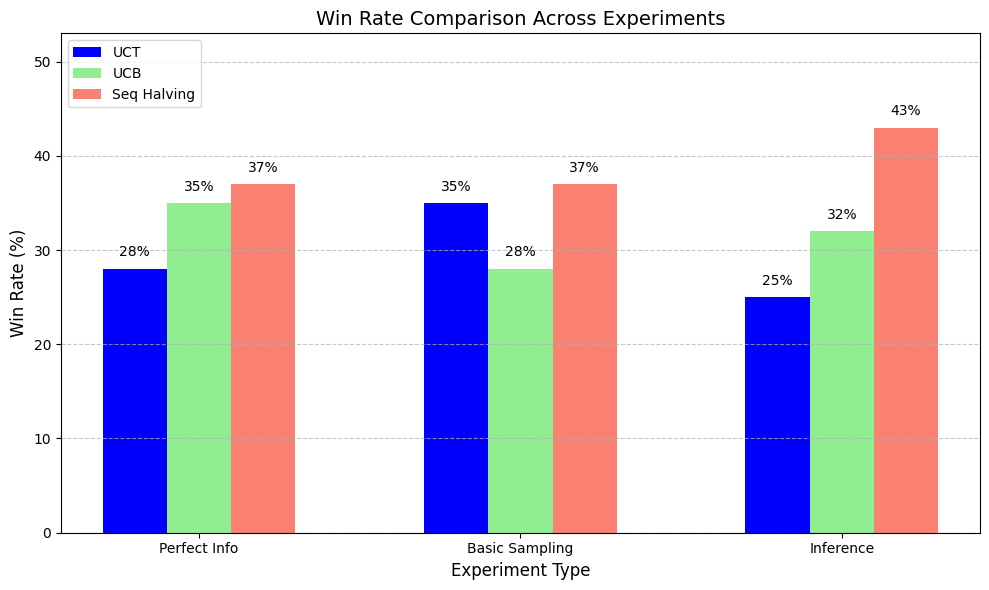

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
methods = ['UCT', 'UCB', 'Seq Halving']
experiments = ['Perfect Info', 'Basic Sampling', 'Inference']
win_rates = [
    [28, 35, 37],   # Perfect Info
    [35, 28, 37],   # Basic Sampling
    [25, 32, 43]    # Inference
]


x = np.arange(len(experiments))
bar_width = 0.2

fig, ax = plt.subplots(figsize=(10,6))

colors = ['blue', 'lightgreen', 'salmon']
for i in range(3):
    bars = ax.bar(x + (i - 1) * bar_width,
                  [row[i] for row in win_rates],
                  width=bar_width, label=methods[i], color=colors[i])


    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height}%',
                ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Experiment Type', fontsize=12)
ax.set_ylabel('Win Rate (%)', fontsize=12)
ax.set_title('Win Rate Comparison Across Experiments', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(experiments)
ax.set_ylim(0, max(max(row) for row in win_rates) + 10)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


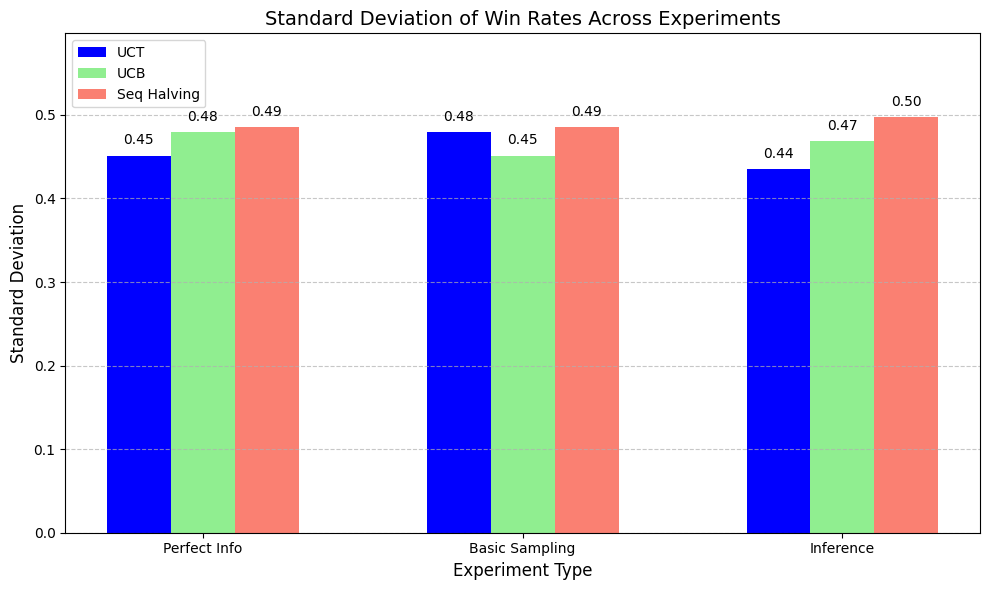

In [ ]:
# Std Deviation Data
std_devs = [
    [0.4513, 0.4794, 0.4852],   # Perfect Info
    [0.4794, 0.4513, 0.4852],   # Basic Sampling
    [0.4352, 0.4688, 0.4976]    # Inference
]

fig, ax = plt.subplots(figsize=(10,6))

for i in range(3):
    bars = ax.bar(x + (i - 1) * bar_width,
                  [row[i] for row in std_devs],
                  width=bar_width, label=methods[i], color=colors[i])


    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}',
                ha='center', va='bottom', fontsize=10)


ax.set_xlabel('Experiment Type', fontsize=12)
ax.set_ylabel('Standard Deviation', fontsize=12)
ax.set_title('Standard Deviation of Win Rates Across Experiments', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(experiments)
ax.set_ylim(0, max(max(row) for row in std_devs) + 0.1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
